Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

По предоставленным данным необходимо предугадать скорый уход пользователя.

В качестве критерия успешности модели выступает roc_auc >= 0.88.

## 1. Начальные настройки

In [ ]:
!pip install lofo-importance

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.utils import shuffle

from lightgbm import LGBMClassifier
from lofo import LOFOImportance, Dataset, plot_importance

import warnings

In [ ]:
sns.set()
RANDOM = 42
warnings.simplefilter("ignore")

Функция `column_info` показывает информацию по столбцу.

In [ ]:
def column_info(data, column, quantitative=False, mean=True, median=True, 
                hist=True, bins=50):    
    lost = data[column].isna().sum() #смотрим количество пропусков
    total = data.shape[0] #длина всех значений переменной
    print()
    print('*** Информация по столбцу {} ***'.format(column))
    print()
    print('Тип данных столбца {}: {}:'.format(column, data[column].dtype))
    print('В столбце {} пропущено {} из {} строк, что составляет {:.2%}'
          .format(column, lost, total, lost / total)) #считаем процент пропусков
    if quantitative:        
        print('Минимальное значение: {:.2f}'.format(data[column].min()))
        print('Максимальное значение: {:.2f}'.format(data[column].max()))
        if mean:
            print('Среднее значение: {:.2f}'.format(data[column].mean()))
        if median:
            print('Медианное значение: {:.2f}'.format(data[column].median()))
        if hist:
            print()
            gridsize = (5, 1)
            fig = plt.figure(figsize=(15, 5))
            ax1 = plt.subplot2grid(gridsize, (0, 0))
            ax2 = plt.subplot2grid(gridsize, (1, 0), rowspan=4)                       
            sns.boxplot(x=data[column], ax=ax1)            
            try: 
                sns.histplot(data[column], kde=False, bins=bins, ax=ax2)
            except:
                sns.distplot(data[column], kde=False, bins=bins, ax=ax2)             
            ax1.get_xaxis().set_visible(False)            
            plt.show()                        
    else:
        print()
        print('Количество значений в каждой из категорий:')
        print(data[column].value_counts())        
    print()

Функция `binary_unsample` выравнивает баланс классов в отношении 1:1.

In [ ]:
def binary_upsample(df, target_column, random_state=None):

    df_ones = df[df[target_column] == 1]
    df_zeros = df[df[target_column] == 0]
    n_ones = len(df_ones)
    n_zeros = len(df_zeros)  

    if n_ones < n_zeros:
        flag = False
    else:
        flag = True    
    
    if flag:
        k_int = n_ones // n_zeros
        k_res = n_ones % n_zeros
        df_upsampled = pd.concat(
            [df_zeros] * k_int + 
            [df_zeros.sample(k_res, random_state=random_state)]+ [df_ones])
    else:
        k_int = n_zeros // n_ones
        k_res = n_zeros % n_ones
        df_upsampled = pd.concat(
            [df_ones] * k_int + 
            [df_ones.sample(k_res, random_state=random_state)]+ [df_zeros])

    return shuffle(df_upsampled, random_state=random_state)

## 2. Исследовательский анализ

In [ ]:
contract = pd.read_csv('contract.csv', index_col='customerID')
contract.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(6)
memory usage: 440.2+ KB


In [ ]:
contract.columns = [i.lower() for i in contract.columns]
contract.sample(5, random_state=RANDOM)

,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges
customerID,,,,,,,
1024-GUALD,2019-10-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,24.80,24.8
0484-JPBRU,2016-09-01,No,Month-to-month,Yes,Bank transfer (automatic),25.25,996.45
3620-EHIMZ,2015-10-01,No,Two year,No,Mailed check,19.35,1031.7
6910-HADCM,2019-09-01,2019-10-01 00:00:00,Month-to-month,No,Electronic check,76.35,76.35
8587-XYZSF,2014-07-01,No,Two year,No,Bank transfer (automatic),50.55,3260.1


Переводим столбцы `begindate` и `enddate` в формат `datetime` для того, чтобы вычислить продолжительность `duration` контракта.
Создаём целевой признак `target`.

In [ ]:
contract['begindate'] = pd.to_datetime(contract['begindate'])
contract['target'] = contract['enddate'].apply(lambda x: 1 if x == 'No' else 0)
contract['enddate'] = contract['enddate'].replace('No', '2020-02-01')
contract['enddate'] = pd.to_datetime(contract['enddate'])
contract['duration'] = (contract['enddate'] - contract['begindate']).dt.days

Cтолбцы `begindate` и `enddate` нам больше не нужны, как и столбец `totalcharges`, так как он линейно зависим от столбцов `monthlycharges` и `duration`.

In [ ]:
contract = contract[
  ['type', 'paperlessbilling', 'paymentmethod', 'monthlycharges', 
   'target', 'duration']]

In [ ]:
column_info(contract, 'type')


*** Информация по столбцу type ***

Тип данных столбца type: object:
В столбце type пропущено 0 из 7043 строк, что составляет 0.00%

Количество значений в каждой из категорий:
Month-to-month    3875
Two year          1695
One year          1473
Name: type, dtype: int64



Переводим значения `Yes` и `No` вручную, чтобы им точно присвоились значения 1 и 0 соотвественно. 

In [ ]:
contract.loc[:, 'paperlessbilling'] = (
    contract['paperlessbilling'].map({'No' : 0, 'Yes' : 1}))
column_info(contract, 'paperlessbilling')


*** Информация по столбцу paperlessbilling ***

Тип данных столбца paperlessbilling: int64:
В столбце paperlessbilling пропущено 0 из 7043 строк, что составляет 0.00%

Количество значений в каждой из категорий:
1    4171
0    2872
Name: paperlessbilling, dtype: int64



In [ ]:
column_info(contract, 'paymentmethod')


*** Информация по столбцу paymentmethod ***

Тип данных столбца paymentmethod: object:
В столбце paymentmethod пропущено 0 из 7043 строк, что составляет 0.00%

Количество значений в каждой из категорий:
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: paymentmethod, dtype: int64



Интрепретируем отсутствие значений в столбце `totalcharges` как отсуствие платежа.


*** Информация по столбцу monthlycharges ***

Тип данных столбца monthlycharges: float64:
В столбце monthlycharges пропущено 0 из 7043 строк, что составляет 0.00%
Минимальное значение: 18.25
Максимальное значение: 118.75
Среднее значение: 64.76
Медианное значение: 70.35



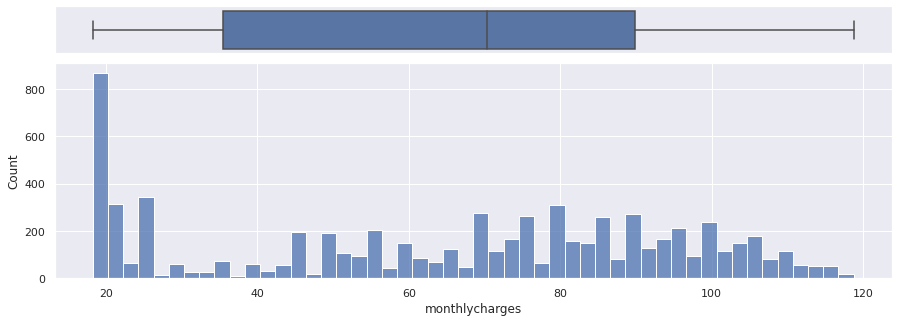

In [ ]:
contract.loc[:, 'monthlycharges'] = (
    contract.loc[:, 'monthlycharges'].astype(float))
column_info(contract, 'monthlycharges', True)


*** Информация по столбцу duration ***

Тип данных столбца duration: int64:
В столбце duration пропущено 0 из 7043 строк, что составляет 0.00%
Минимальное значение: 0.00
Максимальное значение: 2191.00
Среднее значение: 986.00
Медианное значение: 883.00



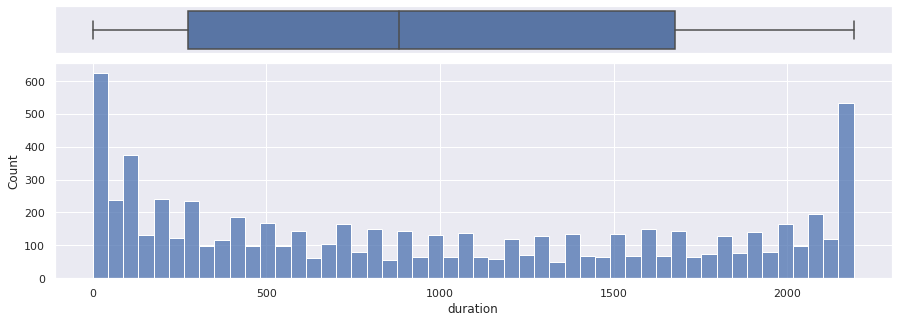

In [ ]:
column_info(contract, 'duration', True)

In [ ]:
column_info(contract, 'target')


*** Информация по столбцу target ***

Тип данных столбца target: int64:
В столбце target пропущено 0 из 7043 строк, что составляет 0.00%

Количество значений в каждой из категорий:
1    5174
0    1869
Name: target, dtype: int64



Замечен дисбаланс классов, хоть он и небольшой.

In [ ]:
internet = pd.read_csv('internet.csv', index_col='customerID')
internet.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   5517 non-null   object
 1   OnlineSecurity    5517 non-null   object
 2   OnlineBackup      5517 non-null   object
 3   DeviceProtection  5517 non-null   object
 4   TechSupport       5517 non-null   object
 5   StreamingTV       5517 non-null   object
 6   StreamingMovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB


In [ ]:
internet.sample(5, random_state=RANDOM)

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
1170-SASML,Fiber optic,No,Yes,Yes,No,No,No
9314-QDMDW,DSL,No,Yes,No,No,Yes,No
2434-EEVDB,Fiber optic,Yes,No,Yes,No,Yes,No
7672-VFMXZ,DSL,Yes,No,No,Yes,No,No
7445-WMRBW,DSL,No,Yes,Yes,Yes,Yes,No


In [ ]:
internet.columns = [i.lower() for i in internet.columns]

In [ ]:
column_info(internet, 'internetservice')

internet.loc[:, 'internetservice'] = (
    internet['internetservice'].map({'DSL' : 0, 'Fiber optic' : 1}))


*** Информация по столбцу internetservice ***

Тип данных столбца internetservice: object:
В столбце internetservice пропущено 0 из 5517 строк, что составляет 0.00%

Количество значений в каждой из категорий:
Fiber optic    3096
DSL            2421
Name: internetservice, dtype: int64



In [ ]:
for i in internet.columns[1:]:
    column_info(internet, i)
    internet.loc[:, i] = (internet[i].map({'No' : 0, 'Yes' : 1}))


*** Информация по столбцу onlinesecurity ***

Тип данных столбца onlinesecurity: object:
В столбце onlinesecurity пропущено 0 из 5517 строк, что составляет 0.00%

Количество значений в каждой из категорий:
No     3498
Yes    2019
Name: onlinesecurity, dtype: int64


*** Информация по столбцу onlinebackup ***

Тип данных столбца onlinebackup: object:
В столбце onlinebackup пропущено 0 из 5517 строк, что составляет 0.00%

Количество значений в каждой из категорий:
No     3088
Yes    2429
Name: onlinebackup, dtype: int64


*** Информация по столбцу deviceprotection ***

Тип данных столбца deviceprotection: object:
В столбце deviceprotection пропущено 0 из 5517 строк, что составляет 0.00%

Количество значений в каждой из категорий:
No     3095
Yes    2422
Name: deviceprotection, dtype: int64


*** Информация по столбцу techsupport ***

Тип данных столбца techsupport: object:
В столбце techsupport пропущено 0 из 5517 строк, что составляет 0.00%

Количество значений в каждой из категорий:
N

In [ ]:
personal = pd.read_csv('personal.csv', index_col='customerID')
personal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   int64 
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB


In [ ]:
personal.sample(5, random_state=RANDOM)

,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
1024-GUALD,Female,0,Yes,No
0484-JPBRU,Male,0,No,No
3620-EHIMZ,Female,0,Yes,Yes
6910-HADCM,Female,0,No,No
8587-XYZSF,Male,0,No,No


In [ ]:
personal.columns = [i.lower() for i in personal.columns]

In [ ]:
column_info(personal, 'gender')
personal.loc[:, 'gender'] = personal['gender'].map({'Male' : 1, 'Female' : 0})


*** Информация по столбцу gender ***

Тип данных столбца gender: object:
В столбце gender пропущено 0 из 7043 строк, что составляет 0.00%

Количество значений в каждой из категорий:
Male      3555
Female    3488
Name: gender, dtype: int64



In [ ]:
column_info(personal, 'seniorcitizen')


*** Информация по столбцу seniorcitizen ***

Тип данных столбца seniorcitizen: int64:
В столбце seniorcitizen пропущено 0 из 7043 строк, что составляет 0.00%

Количество значений в каждой из категорий:
0    5901
1    1142
Name: seniorcitizen, dtype: int64



In [ ]:
for i in ['partner', 'dependents']:
    column_info(personal, i)
    personal.loc[:, i] = personal[i].map({'No' : 0, 'Yes' : 1})


*** Информация по столбцу partner ***

Тип данных столбца partner: object:
В столбце partner пропущено 0 из 7043 строк, что составляет 0.00%

Количество значений в каждой из категорий:
No     3641
Yes    3402
Name: partner, dtype: int64


*** Информация по столбцу dependents ***

Тип данных столбца dependents: object:
В столбце dependents пропущено 0 из 7043 строк, что составляет 0.00%

Количество значений в каждой из категорий:
No     4933
Yes    2110
Name: dependents, dtype: int64



In [ ]:
phone = pd.read_csv('phone.csv', index_col='customerID')
phone.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB


In [ ]:
phone.sample(5, random_state=RANDOM)

,MultipleLines
customerID,
5887-IKKYO,Yes
7718-UPSKJ,No
3571-DPYUH,Yes
3769-MHZNV,No
6732-FZUGP,Yes


In [ ]:
phone.columns = [phone.columns[0].lower()]

In [ ]:
column_info(phone, 'multiplelines')
phone.loc[:, 'multiplelines'] = (
phone['multiplelines'].map({'No' : 0, 'Yes' : 1}))


*** Информация по столбцу multiplelines ***

Тип данных столбца multiplelines: object:
В столбце multiplelines пропущено 0 из 6361 строк, что составляет 0.00%

Количество значений в каждой из категорий:
No     3390
Yes    2971
Name: multiplelines, dtype: int64



Объединяем все таблицы внешним образом по индексу. После заполним все пропущенные значения 0. Так как 0 обозначает отсутствие услуги.

In [ ]:
full = contract.join([internet, personal, phone], how='outer')
full.fillna(0, inplace=True)

Оставшиеся категориальные признаки переводим в количественные методом `get_dummies` для того, чтобы использовать их в тех алгоритмах(например, логистическая регрессия), которые использую арифметические операции по ним.

In [ ]:
full = pd.get_dummies(full, drop_first=True)
full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   paperlessbilling                       7043 non-null   int64  
 1   monthlycharges                         7043 non-null   float64
 2   target                                 7043 non-null   int64  
 3   duration                               7043 non-null   int64  
 4   internetservice                        7043 non-null   float64
 5   onlinesecurity                         7043 non-null   float64
 6   onlinebackup                           7043 non-null   float64
 7   deviceprotection                       7043 non-null   float64
 8   techsupport                            7043 non-null   float64
 9   streamingtv                            7043 non-null   float64
 10  streamingmovies                        7043 non-null   float64

## 3. Подготовка

Приводим соотношение классов к балансу.

In [ ]:
full = binary_upsample(full, 'target', random_state=RANDOM)

Выделяем целевой признак.

In [ ]:
X = full.drop('target', axis=1)
y = full['target']

Выделяем обучающую и тестовую выборки в отношении 3:1.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM)

`train` понадобится нам для поиска наиболее значимых признаков.

In [ ]:
train = X_train.join(y_train)

## 4. Обучение

### 4.1 lgb

С помощью библиотеки `lofo` определяем те признаки, которые положительно влияют на финальную метрику для данного решателя (по умолчанию это lgb). Поиск признаков осуществим только по обучающей выборке, чтобы не было утечек.

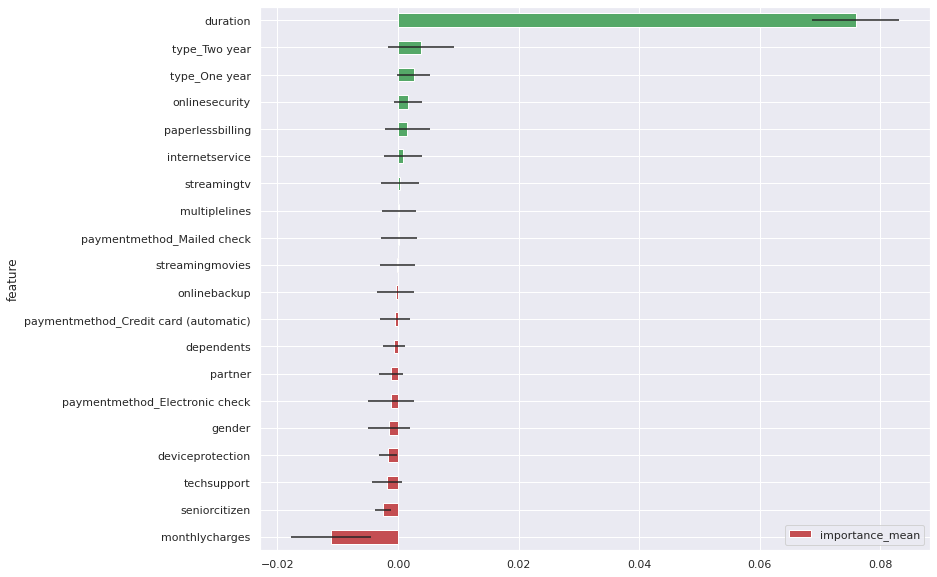

In [ ]:
cv = KFold(n_splits=5, shuffle=False)

dataset = Dataset(
    df=train, target="target", 
    features=[col for col in train.columns if col != 'target'])

lofo_imp = LOFOImportance(dataset, cv=cv, scoring="roc_auc")
importance_df = lofo_imp.get_importance()
plot_importance(importance_df, figsize=(12, 10))

Выбираем первые 8 по значимости признаки.

In [ ]:
features = importance_df['feature'][:8].values.tolist()
X_train_lgb = X_train[features]
X_test_lgb = X_test[features]

In [ ]:
lgb = LGBMClassifier()

parameters = {
    'learning_rate': [0.01, 0.1, 1, 10],
    'max_depth': [2, 3, 4, 5],
    'num_leaves': [2, 5, 10, 15],
    'n_estimators': [200, 300, 400, 500]}

lgb_grid = GridSearchCV(
    estimator=lgb, 
    param_grid=parameters,
    n_jobs=-1, 
    scoring='roc_auc')

lgb_grid.fit(X_train_lgb, y_train)

lgb_score = roc_auc_score(
    y_test, 
    lgb_grid.best_estimator_.predict_proba(X_test_lgb)[:,1])

print('Best score: {:.3f}'.format(lgb_grid.best_score_))
print('Test score: {:.3f}'.format(lgb_score))
print('Best parameters:', lgb_grid.best_params_)

Best score: 0.960
Test score: 0.968
Best parameters: {'learning_rate': 1, 'max_depth': 5, 'n_estimators': 300, 'num_leaves': 15}


### 4.2 ridge

Попробуем линейную модель.

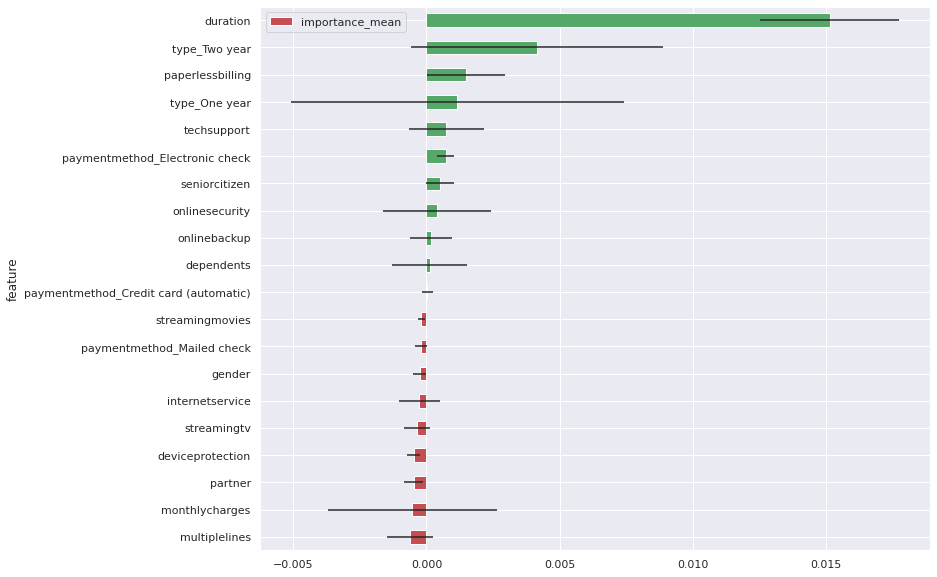

In [ ]:
cv = KFold(n_splits=5, shuffle=False)

dataset = Dataset(
    df=train, target="target", 
    features=[col for col in train.columns if col != 'target'])

lofo_imp = LOFOImportance(
    dataset, 
    cv=cv, 
    scoring="roc_auc", 
    model=RidgeClassifier())

importance_df = lofo_imp.get_importance()
plot_importance(importance_df, figsize=(12, 10))

Выбираем первые 9 по значимости признаков.

In [ ]:
features = importance_df['feature'][:9].values.tolist()
X_train_rid = X_train[features]
X_test_rid = X_test[features]

In [ ]:
rid = RidgeClassifier(random_state=RANDOM)

parameters = {'alpha': [0.01, 1, 10, 100, 200, 300]}

rid_grid = GridSearchCV(
    estimator=rid, 
    param_grid=parameters,
    n_jobs=-1, 
    scoring='roc_auc')

rid_grid.fit(X_train_rid, y_train)
rid_score = roc_auc_score(
    y_test, 
    rid_grid.best_estimator_.decision_function(X_test_rid))

print('Best score: {:.3f}'.format(rid_grid.best_score_))
print('Test score: {:.3f}'.format(rid_score))
print('Best parameters:', rid_grid.best_params_)

Best score: 0.816
Test score: 0.826
Best parameters: {'alpha': 100}


### 4.3 knn

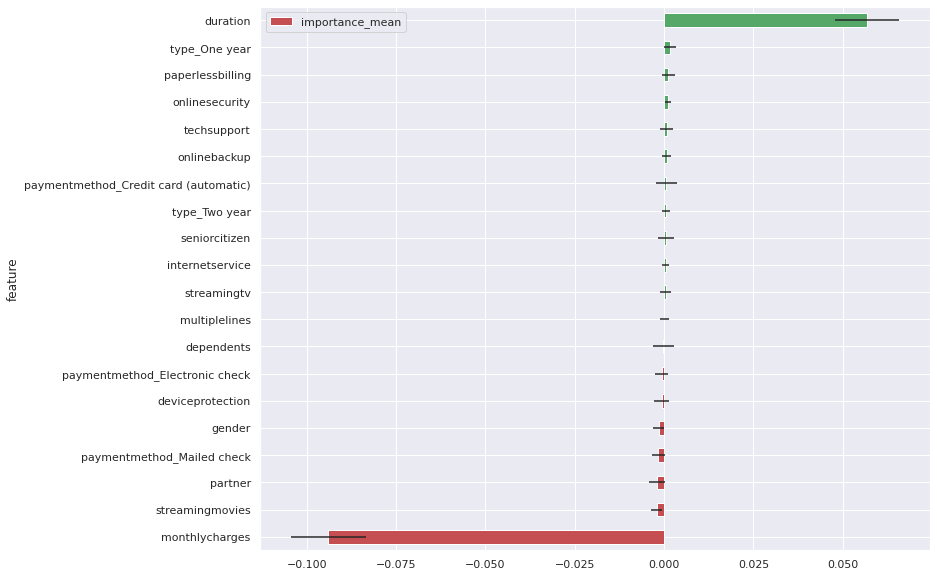

In [ ]:
cv = KFold(n_splits=5, shuffle=False)

dataset = Dataset(
    df=train, target="target", 
    features=[col for col in train.columns if col != 'target'])

lofo_imp = LOFOImportance(
    dataset, 
    cv=cv, 
    scoring="roc_auc", 
    model=KNeighborsClassifier())

importance_df = lofo_imp.get_importance()
plot_importance(importance_df, figsize=(12, 10))

Выбираем первые 5 по значимости признаков.

In [ ]:
features = importance_df['feature'][:5].values.tolist()
X_train_knn = X_train[features]
X_test_knn = X_test[features]

In [ ]:
knn = KNeighborsClassifier(n_jobs=-1)

parameters = {'n_neighbors': [2, 4, 6, 8, 10],
              'metric': ['euclidean', 'manhattan', 'chebyshev']}

knn_grid = GridSearchCV(
    estimator=knn, 
    param_grid=parameters,
    n_jobs=-1, 
    scoring='roc_auc')

knn_grid.fit(X_train_knn, y_train)
knn_score = roc_auc_score(
    y_test, 
    knn_grid.best_estimator_.predict_proba(X_test_knn)[:, 1])

print('Best score: {:.3f}'.format(knn_grid.best_score_))
print('Test score: {:.3f}'.format(knn_score))
print('Best parameters:', knn_grid.best_params_)

Best score: 0.928
Test score: 0.932
Best parameters: {'metric': 'euclidean', 'n_neighbors': 10}


### 4.4 svc

Попробуем машину, основаную на опорных векторах. При предварительном исследовании линейное ядро показало лучший результат, но линейная модель у нас уже есть, поэтому вырберем ядро rbf (по умолчанию).

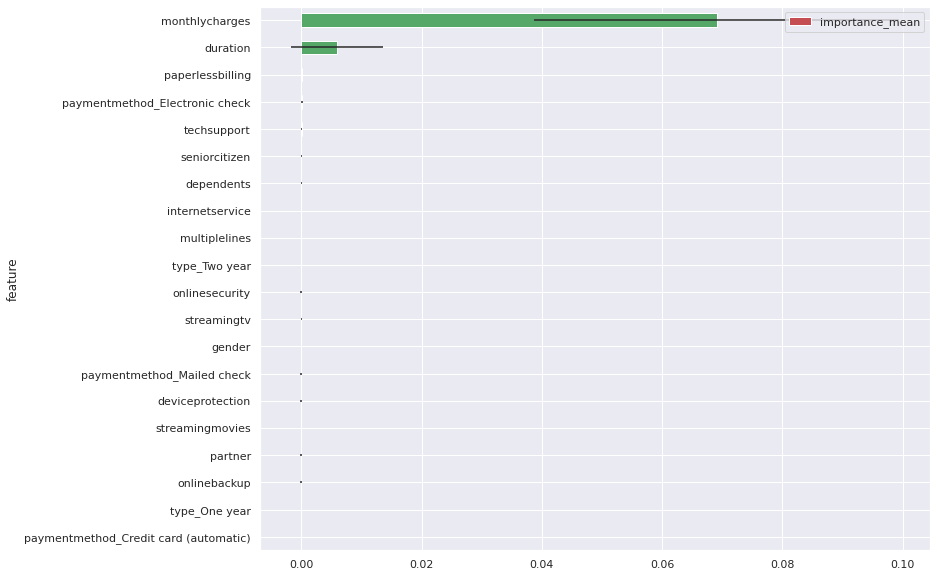

In [ ]:
cv = KFold(n_splits=3, shuffle=False)

dataset = Dataset(
    df=train, target="target", 
    features=[col for col in train.columns if col != 'target'])

lofo_imp = LOFOImportance(
    dataset, 
    cv=cv, 
    scoring="roc_auc", 
    model=SVC())

importance_df = lofo_imp.get_importance()
plot_importance(importance_df, figsize=(12, 10))

Оставляем только 2 признака.

In [ ]:
features = importance_df['feature'][:2].values.tolist()
X_train_svc = X_train[features]
X_test_svc = X_test[features]

In [ ]:
svc = SVC(random_state=RANDOM, probability=True)

parameters = {'C': [.01, .1, 1, 10], 
              'gamma': [.01, .1, 1, 10]}

svc_grid = GridSearchCV(
    estimator=svc, 
    param_grid=parameters,
    n_jobs=-1, 
    cv=3,
    scoring='roc_auc')

svc_grid.fit(X_train_svc, y_train)
svc_score = roc_auc_score(
    y_test, 
    svc_grid.best_estimator_.predict_proba(X_test_svc)[:, 1])

print('Best score: {:.3f}'.format(svc_grid.best_score_))
print('Test score: {:.3f}'.format(svc_score))
print('Best parameters:', svc_grid.best_params_)

Best score: 0.916
Test score: 0.945
Best parameters: {'C': 1, 'gamma': 10}


## 5. Вывод

,performance
lgb,0.967627
svc,0.945279
knn,0.932067
rid,0.825801


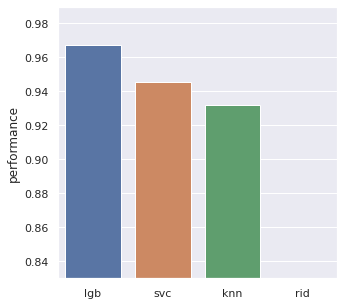

In [ ]:
performance = [lgb_score, rid_score, knn_score, svc_score]
index = ['lgb', 'rid', 'knn', 'svc']           

results = pd.DataFrame(
    {'performance': performance},
     index=index).sort_values(by='performance', ascending=False)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()
sns.barplot(x=results.index, y='performance', data=results)
ax.set_ylim(.83, .99)
fig.show()

results.sort_values(by='performance', ascending=False)

В качестве проверки адекватности модели можно просто взять критерий roc_auc > 0.5, так как именно такую метрику показывает констрантная модель.

Наилучший результат показала модель lgb. Градиентный бустинг в очередной раз всех побил. Но не исключено, что svc-модель можно значительно улучшить подбором параметров (что и случилось при повторном пересчёте), но слишком уж она много потребляет ресурсов. Примечательно, что при этом она в основном использовала только 2 признака `duration` и `monthlycharges`. Учитывая то, что эти признаки имеют очевидную корреляцию, то получается, что вероятность ухода клиента почти полностью зависит от продолжительности пользования услугами.

Были проведены рассчёты со `scaler`, но они дали результаты хуже.

Результат с точки зрения человеческой лигики почти очевиден: вероятность ухода клиента почти полностью зависит от продолжительности пользования сервисами провайдера (количеством заплаченных денег за все услуги). Наверное, это можно назвать одним словом - лояльность.

Тем не менее, можно усилить задачу. Важно отследить, как меняется поведение клиента во времени, наверняка в поведенческих изменениях содержится гораздо больше информации. Например, падение интенсивности пользования сервисами провайдера - явный сигнал к скорому отключению.

Поэтому для дальнейшего исследования могу предложить рассмотреть задачу с временными рядами и интенсивностью использования интернета и телефонной связи.

